# ManuscriptS5b - Predicting task performance using information transfer estimates

## Analysis for Supplementary Figure 5


## Master code for Ito et al., 2017¶
#### Takuya Ito (takuya.ito@rutgers.edu)



In [2]:
import sys
import os
sys.path.append('utils/')
import numpy as np
import loadGlasser as lg
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.sandbox.stats.multicomp as mc
import sys
import multiprocessing as mp
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import nibabel as nib
os.environ['OMP_NUM_THREADS'] = str(1)

from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm



class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
class MidpointNormalize2(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        t1 = (self.midpoint - self.vmin)/2.0
        t2 = (self.vmax - self.midpoint)/30.0 + self.midpoint
        x, y = [self.vmin, t1, self.midpoint, t2, self.vmax], [0, 0.25, .5, .75, 1.0]
        return np.ma.masked_array(np.interp(value, x, y))

# 0.0 Basic parameters

In [3]:
# Set basic parameters
basedir = '/projects2/ModalityControl2/'
datadir = basedir + 'data/'
resultsdir = datadir + 'resultsMaster/'
runLength = 4648

subjNums = ['032', '033', '037', '038', '039', '045', 
            '013', '014', '016', '017', '018', '021', 
            '023', '024', '025', '026', '027', '031', 
            '035', '046', '042', '028', '048', '053', 
            '040', '049', '057', '062', '050', '030', '047', '034']

glasserparcels = lg.loadGlasserParcels()
networkdef = lg.loadGlasserNetworks()


networkmappings = {'fpn':7, 'vis':1, 'smn':2, 'con':3, 'dmn':6, 'aud1':8, 'aud2':9, 'dan':11}
# Force aud2 key to be the same as aud1
aud2_ind = np.where(networkdef==networkmappings['aud2'])[0]
networkdef[aud2_ind] = networkmappings['aud1']
# Define new network mappings with no aud1/aud2 distinction
networkmappings = {'fpn':7, 'vis':1, 'smn':2, 'con':3, 'dmn':6, 'aud':8, 'dan':11,
                   'prem':5, 'pcc':10, 'none':12, 'hipp':13, 'pmulti':14}
netkeys = {0:'fpn', 1:'dan', 2:'con', 3:'dmn', 4:'vis', 5:'aud', 6:'smn'}

nParcels = 360

# Import network reordering
networkdir = '/projects/AnalysisTools/netpartitions/ColeLabNetPartition_v1/'
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
order = networkorder
order.shape = (len(networkorder),1)

# Construct xticklabels and xticks for plotting figures
networks = networkmappings.keys()
xticks = {}
reorderednetworkaffil = networkdef[order]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net
    
# Load in Glasser parcels in their native format
glasserfile2 = '/projects/AnalysisTools/ParcelsGlasser2016/archive/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_LR.dlabel.nii'
glasser2 = nib.load('/projects/AnalysisTools/ParcelsGlasser2016/archive/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_LR.dlabel.nii')
glasser2 = glasser2.get_data()
glasser2 = glasser2[0][0][0][0][0]


def convertCSVToCIFTI64k(inputfilename,outputfilename):
    ciftitemplate = glasserfile2
    wb_command = 'wb_command -cifti-convert -from-text' 
    wb_command += ' ' + inputfilename 
    wb_command += ' ' + ciftitemplate
    wb_command += ' ' + outputfilename
    wb_command += " -col-delim ','"
    wb_command += ' -reset-scalars'
    os.system(wb_command)
#     print wb_command

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


## 0.1 Load in behavioral data (performance + RT)

In [3]:
behavdata = {}
for subj in subjNums:
    behavdata[subj] = {}
    behavdir = basedir + 'data/resultsMaster/behavresults/'
    behavdata[subj]['acc'] = np.loadtxt(behavdir + subj + '_accuracy.csv',dtype='str',delimiter=',')
    behavdata[subj]['rt'] = np.loadtxt(behavdir + subj + '_RT.csv')

#### Write out miniblock-by-miniblock accuracy performance for within-subject region-to-region logistic regression with information transfer estimates (for revision)

In [4]:
n_mbs = 128
ntrialspermb = 3
for subj in subjNums:
    filename = basedir + 'data/resultsMaster/behavresults/' + subj+'_acc_by_mb.txt'
    tmp = behavdata[subj]['acc']=='Correct'
    tmp = tmp.astype(int)
    mb_tmp = []
    count = 0
    for mb in range(n_mbs):
        mb_tmp.append(np.mean(tmp[count:(count+ntrialspermb)]))
        count += ntrialspermb
    mb_tmp = np.asarray(mb_tmp)
    np.savetxt(filename, mb_tmp)

#### Do the same for RT

In [5]:
n_mbs = 128
ntrialspermb = 3
for subj in subjNums:
    filename = '/projects2/ModalityControl2/data/resultsMaster/behavresults/' + subj+'_rt_by_mb.txt'
    tmp = behavdata[subj]['rt']
    mb_tmp = []
    count = 0
    for mb in range(n_mbs):
        mb_tmp.append(np.mean(tmp[count:(count+ntrialspermb)]))
        count += ntrialspermb
    mb_tmp = np.asarray(mb_tmp)
    np.savetxt(filename, mb_tmp)

## 0.2 Verify normality of behavioral data

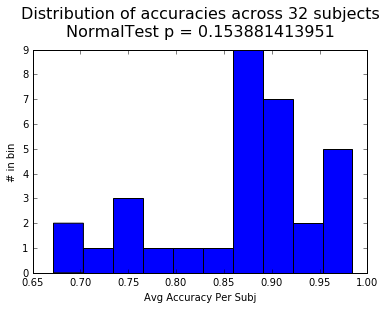

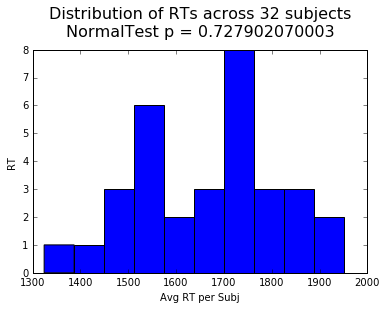

In [6]:
acc = []
rt = []
for subj in subjNums:
    acc.append(np.mean(behavdata[subj]['acc']=='Correct'))
    rt.append(np.mean(behavdata[subj]['rt']))
    
plt.figure()
plt.hist(acc)
plt.title('Distribution of accuracies across 32 subjects\nNormalTest p = '+str(stats.normaltest(acc)[1]),
          y=1.04,fontsize=16)
plt.xlabel('Avg Accuracy Per Subj')
plt.ylabel('# in bin')

plt.figure()
plt.hist(rt,bins=10)
plt.title('Distribution of RTs across 32 subjects\nNormalTest p = '+str(stats.normaltest(rt)[1]),
          y=1.04,fontsize=16)
plt.xlabel('Avg RT per Subj')
plt.ylabel('RT')

# 1.0 Run Information transfer mapping

##### Due to obvious computational constraints, all region-to-region ActFlow procedures and RSA analyses were run on NM3 
#### Code: ./SupercomputerScripts/Fig6_RegionToRegionInformationTransferMapping/ActFlow_ITE_DecodePerformance_LogRegression_v2.m


# 2.0 Identify information transfers that are correlated with behavior

#### Load in logistic regression betas

In [7]:
## Load in NM3 Data
datadir = '/projects2/ModalityControl2/data/resultsMaster/Manuscript6andS2and7_RegionToRegionITE/'
# Load in RSA matrices
logitBetas= np.zeros((nParcels,nParcels,len(subjNums)))
scount = 0
for subj in subjNums:
    filename = datadir +subj+'_RegionToRegionActFlowGlasserParcels_BehavioralAcc.csv'
    logitBetas[:,:,scount] = np.loadtxt(filename, delimiter=',')
    scount += 1

#### Perform group statistics


In [8]:
df_stats = {}
df_stats['logit_t'] = np.zeros((nParcels,nParcels))
df_stats['logit_p'] = np.ones((nParcels,nParcels))
df_stats['logit_q'] = np.ones((nParcels,nParcels))
df_stats['logit_avg'] = np.mean(logitBetas,axis=2)
for i in range(nParcels):
    for j in range(nParcels):
        if i==j: continue
        t, p = stats.ttest_1samp(logitBetas[i,j,:],.5)
        if t > 0:
            p = p/2.0
        else:
            p = 1.0 - p/2.0
        df_stats['logit_t'][i,j] = t
        df_stats['logit_p'][i,j] = p


In [9]:
roi = 260
# indices = np.where((networkdef==networkmappings['fpn']) | (networkdef==networkmappings['con']))[0]
# # indices = np.where(networkdef==networkmappings['con'])[0]
fpn_ind = np.where(networkdef==networkmappings['fpn'])[0]
fpn_ind.shape = (len(fpn_ind),1)
con_ind = np.where(networkdef==networkmappings['con'])[0]
con_ind.shape = (len(con_ind),1)
# indices = np.arange(nParcels)
mat = np.zeros((nParcels,nParcels))

# mat[260,:] = 1
# mat[:,260] = 1
mat[260,fpn_ind.T] = 1
mat[260,con_ind.T] = 1
# mat[fpn_ind,con_ind.T] = 1
# mat[fpn_ind,fpn_ind.T] = 1
# mat[con_ind,con_ind.T] = 1
# mat[con_ind,fpn_ind.T] = 1
# mat = np.ones((nParcels,nParcels))
# mat[:,roi] = 1
np.fill_diagonal(mat,0)
indices = np.where(mat==1)

# Perform multiple comparisons
#     df_stats['logit_q'][sig_ind] = mc.fdrcorrection0(df_stats['logit_p'][sig_ind])[1]
df_stats['logit_q'] = np.ones((nParcels,nParcels))
df_stats['logit_q'][indices] = mc.fdrcorrection0(df_stats['logit_p'][indices])[1]

ind = np.where(df_stats['logit_q']<0.05)
print 'Significant transfers predicted of performance:'
count = 0
for i in range(len(ind[0])):
    print 'Transfers from', ind[0][count], 'to', ind[1][count]
    print 'Effect size =', df_stats['logit_avg'][ind[0][count],ind[1][count]]
    print 'p =', df_stats['logit_p'][ind[0][count],ind[1][count]]
    print 'q =', df_stats['logit_q'][ind[0][count],ind[1][count]]
    count += 1

Significant transfers predicted of performance:
Transfers from 260 to 271
Effect size = 0.532225625
p = 2.10645113216e-05
q = 0.00200112857555


___

# FWE correction on results
#### Perform group statistics


In [12]:
df_stats = {}
df_stats['logit_t'] = np.zeros((nParcels,nParcels))
df_stats['logit_p'] = np.ones((nParcels,nParcels))
df_stats['logit_q'] = np.ones((nParcels,nParcels))
df_stats['logit_avg'] = np.mean(logitBetas,axis=2)
for i in range(nParcels):
    for j in range(nParcels):
        if i==j: continue
        t, p = stats.ttest_1samp(logitBetas[i,j,:],.5)
        if t > 0:
            p = p/2.0
        else:
            p = 1.0 - p/2.0
        df_stats['logit_t'][i,j] = t
        df_stats['logit_p'][i,j] = p


In [14]:
roi = 260
# indices = np.where((networkdef==networkmappings['fpn']) | (networkdef==networkmappings['con']))[0]
# # indices = np.where(networkdef==networkmappings['con'])[0]
fpn_ind = np.where(networkdef==networkmappings['fpn'])[0]
fpn_ind.shape = (len(fpn_ind),1)
con_ind = np.where(networkdef==networkmappings['con'])[0]
con_ind.shape = (len(con_ind),1)
# indices = np.arange(nParcels)
mat = np.zeros((nParcels,nParcels))

# mat[260,:] = 1
# mat[:,260] = 1
mat[260,fpn_ind.T] = 1
mat[260,con_ind.T] = 1
# mat[fpn_ind,con_ind.T] = 1
# mat[fpn_ind,fpn_ind.T] = 1
# mat[con_ind,con_ind.T] = 1
# mat[con_ind,fpn_ind.T] = 1
# mat = np.ones((nParcels,nParcels))
# mat[:,roi] = 1
np.fill_diagonal(mat,0)
indices = np.where(mat==1)

# Permutation testing
import permutationTesting as pt
chance = .5
tmp = logitBetas - chance # Subtract decoding accuracies by chance
t, p = pt.permutationFWE(tmp[indices[0],indices[1],:], permutations=1000, nproc=15)
pfwe = np.zeros((nParcels,nParcels))
tfwe = np.zeros((nParcels,nParcels))
pfwe[indices] = p
tfwe[indices] = t

ind = np.where(pfwe>0.95)
print 'Significant transfers predictive of performance:'
count = 0
for i in range(len(ind[0])):
    print 'Transfers from', ind[0][count], 'to', ind[1][count]
    print 'Effect size =', df_stats['logit_avg'][ind[0][count],ind[1][count]]
    print 'T-statistic =', tfwe[ind[0][count],ind[1][count]]
    print 'p (FWE) =', 1.0 - pfwe[ind[0][count],ind[1][count]]
    count += 1

Significant transfers predictive of performance:
Transfers from 260 to 271
Effect size = 0.532225625
T-statistic = 4.76458294182
p (FWE) = 0.0


___